## Questions to Answer
1. Does Filtering on noise estimates worsen imbalance? Before vs after IR for CLNI, Two-stage ensemble
2. Avg. noise likelihood of minority vs majority class?
3. Ratio of 0->1 & 1->0 noise types vs ratio of noisy samples identified in each class. With oracle access to no of actual, total no. of noisy samples 

In [1]:
import numpy as np,os
import pandas as pd
from sklearn.metrics import matthews_corrcoef, precision_recall_curve, auc, accuracy_score, precision_score, recall_score
import seaborn as sns,matplotlib.pyplot as plt

from library.utils import evaluate, read_data
from library.cleaners import kDN, ih_prob

/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


## Notes
+ Using `kDN(K=5)`: In `25/32` datasets, no of samples with NP noise (Bug class in noisy dataset but actually Clean) has been overestimated. Consequently PN has been underestimated. This shows minority class gets disproportionately affected.
    + For `ih_prob`: that number is `23/32`
+ In terms of avg. probability of being noisy: samples in Bug class (of noisy data version) have vastly hugher value than clean ones. On further avg on 32 datasets, `.702 vs .074`, almost 10 times higher.

In [2]:
DATASETS = ['groovy-1_5_7.csv','jruby-1.4.0.csv','lucene-2.9.0.csv','jruby-1.7.0.preview1.csv','groovy-1_6_BETA_1.csv',
        'derby-10.2.1.6.csv','wicket-1.5.3.csv','camel-2.9.0.csv','camel-1.4.0.csv','activemq-5.8.0.csv']
DATASETS = [f for f in os.listdir("JIRA/") if 'csv' in f]
len(DATASETS)

32

In [15]:
df = pd.DataFrame(index=DATASETS,columns=['PN','ePN','NP','eNP','avg-bug','avg-clean'])
for d in DATASETS:
    X,y_noisy,y_real = read_data(d,True)
    PN = y_noisy[y_real==1]==0   #So, really 1(P), but now 0(N)
    NP = y_noisy[y_real==0]==1   #So, really 0(N), but now 1(P)
    assert PN.sum()+NP.sum()==(y_noisy!=y_real).sum()
    print(f"PN {PN.sum()},NP {NP.sum()}")
    ne = ih_prob(X,y_noisy,K=5)
    avg_bug,avg_clean = ne[y_noisy==1].mean(),ne[y_noisy==0].mean()  #avg_bug: avg noise probs of those labelled Buggy in Noisy dataset
    actual_total = (y_noisy!=y_real).sum()
    nidx = np.argsort(ne)[-actual_total:]
    eNP = y_noisy[nidx]==1
    ePN = y_noisy[nidx]==0
    print(f"ePN {ePN.sum()},eNP {eNP.sum()}")
    print(f"Avg, Bug:{avg_bug:.3f}, Clean:{avg_clean:.3f}")
    print()
    df.loc[d,:] = [x.sum() for x in [PN,ePN,NP,eNP]] + [avg_bug,avg_clean]

activemq-5.8.0.csv noise:0.058, imb:15.847,203,3217, Shape:(3420, 65)
PN 100,NP 97
ePN 46,eNP 151
Avg, Bug:0.676, Clean:0.083

groovy-1_6_BETA_1.csv noise:0.128, imb:6.017,117,704, Shape:(821, 65)
PN 29,NP 76
ePN 39,eNP 66
Avg, Bug:0.526, Clean:0.113

activemq-5.3.0.csv noise:0.094, imb:15.669,142,2225, Shape:(2367, 65)
PN 169,NP 53
ePN 110,eNP 112
Avg, Bug:0.620, Clean:0.080

wicket-1.3.0-incubating-beta-1.csv noise:0.164, imb:4.806,288,1384, Shape:(1672, 65)
PN 44,NP 231
ePN 125,eNP 150
Avg, Bug:0.536, Clean:0.137

jruby-1.1.csv noise:0.175, imb:3.540,161,570, Shape:(731, 65)
PN 27,NP 101
ePN 65,eNP 63
Avg, Bug:0.422, Clean:0.153

jruby-1.4.0.csv noise:0.190, imb:3.890,200,778, Shape:(978, 65)
PN 83,NP 103
ePN 80,eNP 106
Avg, Bug:0.520, Clean:0.144

lucene-2.3.0.csv noise:0.204, imb:4.031,160,645, Shape:(805, 65)
PN 100,NP 64
ePN 70,eNP 94
Avg, Bug:0.535, Clean:0.151

hbase-0.95.2.csv noise:0.260, imb:15.088,114,1720, Shape:(1834, 65)
PN 423,NP 54
ePN 371,eNP 106
Avg, Bug:0.693, Clea

In [16]:
df

,PN,ePN,NP,eNP,avg-bug,avg-clean
activemq-5.8.0.csv,100,46,97,151,0.675766,0.0828581
groovy-1_6_BETA_1.csv,29,39,76,66,0.525672,0.113085
activemq-5.3.0.csv,169,110,53,112,0.620039,0.0798181
wicket-1.3.0-incubating-beta-1.csv,44,125,231,150,0.535514,0.13665
jruby-1.1.csv,27,65,101,63,0.422296,0.152668
jruby-1.4.0.csv,83,80,103,106,0.519683,0.144028
lucene-2.3.0.csv,100,70,64,94,0.534671,0.151187
hbase-0.95.2.csv,423,371,54,106,0.693443,0.102486
lucene-3.0.0.csv,106,115,141,132,0.552705,0.14662
camel-2.9.0.csv,156,124,157,189,0.763604,0.0524836


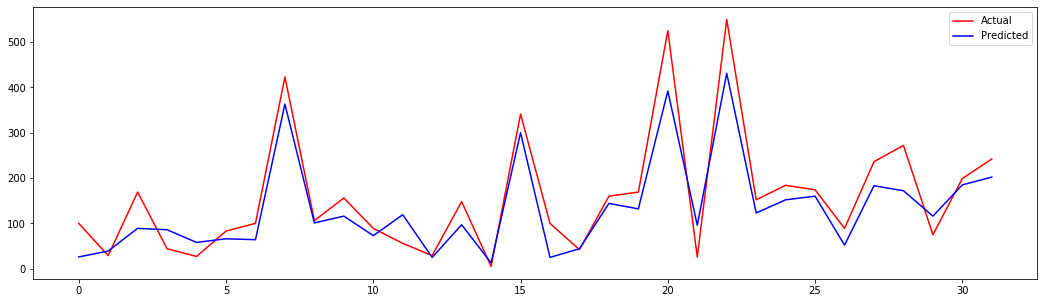

In [5]:
plt.figure(figsize=(18,5))
plt.plot(range(len(DATASETS)),df['PN'],c='r',label='Actual');
plt.plot(range(len(DATASETS)),df['ePN'],c='b',label='Predicted');
plt.legend();

In [6]:
(df['ePN']>df['PN']).sum(),(df['eNP']>df['NP']).sum()

(8, 24)

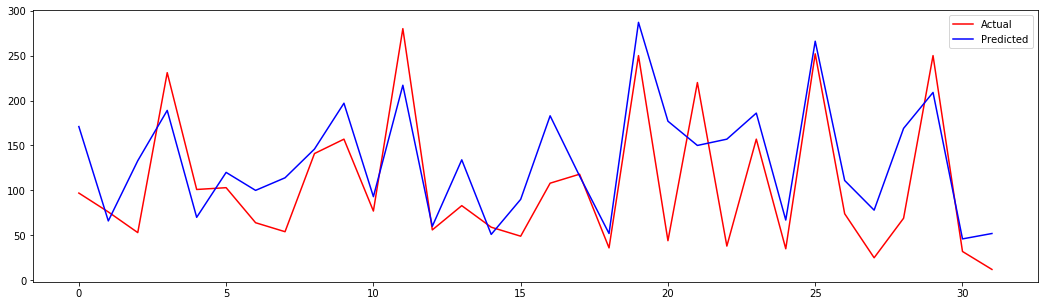

In [7]:
plt.figure(figsize=(18,5))
plt.plot(range(len(DATASETS)),df['NP'],c='r',label='Actual');
plt.plot(range(len(DATASETS)),df['eNP'],c='b',label='Predicted');
plt.legend();

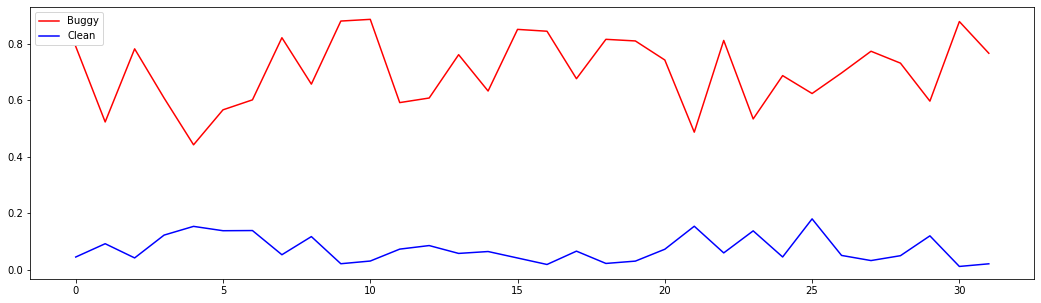

In [11]:
plt.figure(figsize=(18,5))
plt.plot(range(len(DATASETS)),df['avg-bug'],c='r',label='Buggy');
plt.plot(range(len(DATASETS)),df['avg-clean'],c='b',label='Clean');
plt.legend();

In [12]:
df['avg-bug'].mean(),df['avg-clean'].mean()

(0.7022270627726707, 0.07362175333310558)

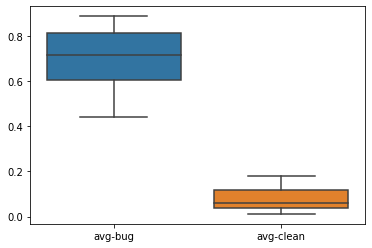

In [13]:

sns.boxplot(data=df[['avg-bug','avg-clean']]);

In [17]:
ih = df.copy()

In [14]:
kdn = df.copy()

In [37]:
a = kdn[['avg-bug','avg-clean']].assign(detect='kDN')
b = ih[['avg-bug','avg-clean']].assign(detect='IH')

In [38]:
tmp = pd.concat([a,b],axis=0)

In [39]:
tt = pd.melt(tmp,id_vars=['detect'])
tt

,detect,variable,value
0,kDN,avg-bug,0.790148
1,kDN,avg-bug,0.523077
2,kDN,avg-bug,0.78169
3,kDN,avg-bug,0.607639
4,kDN,avg-bug,0.442236
...,...,...,...
123,IH,avg-clean,0.0662542
124,IH,avg-clean,0.0901403
125,IH,avg-clean,0.135006
126,IH,avg-clean,0.0466597


In [40]:
tt.columns = ['detector','Class','MCC']

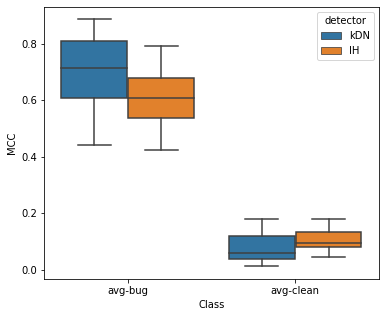

In [42]:
plt.figure(figsize=(6,5));
f = sns.boxplot(x='Class',y='MCC',data=tt,hue='detector');

In [43]:
f.get_figure().savefig("figures/noise_estimates.svg",format='svg');

## Impact on Classification performance
So, both noise detectors discriminate against minority Bug class. But when we incorporate this noise estimates into this imbalanced classification setting, how much does this actually hurt classification performance? Is balancing first better? `Balancing->Filtering` vs `Filtering->Balancing`

In [ ]:
from collections import defaultdict
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.ensemble import BalancedBaggingClassifier, RUSBoostClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler, EditedNearestNeighbours, TomekLinks
from imblearn.pipeline import Pipeline

from library.cleaners import FilteringEstimator

In [ ]:
def evaluateFilter(clf,X,y_noisy,y_real,cv,scorers):
    scores = defaultdict(list)
    to_keep = (y_noisy==y_real).sum()
    for train_id, test_id in cv.split(X,y_real):  #vs y_noisy, to solve no-pos-label-in-test-set bug     
        try:
            clf = clf.fit(X[train_id],y_noisy[train_id],to_keep=to_keep)
            probs = clf.predict_proba(X[test_id])
            assert probs.shape[1]==2
        except (ValueError,AssertionError) as e: 
            #assert str(e).startswith("Expected n_neighbors") or str(e).startswith("The target"),f"Some different Error:{str(e)}"
            for func in scorers:
                scores[func.__name__].append(0)
            print("ERROR")
            continue
        labels = np.argmax(probs,axis=1)
        for func in scorers:
            yp = probs[:,1]
            try:
                func([0,1,1],[.2,.6,.7])
                yp = probs[:,1]
            except ValueError as e:
                yp = labels
            scores[func.__name__].append(func(y_real[test_id],yp))
    for func in scorers:
        scores[func.__name__] = np.array(scores[func.__name__])
    return scores

In [ ]:
imbs = {
    'smote': SMOTE(k_neighbors=5),
    'rus': RandomUnderSampler('not minority'),
    'wilson':EditedNearestNeighbours(n_neighbors=5),  #Default was 3
    'tomek': TomekLinks(),
}
clfs = {
    'dt': DecisionTreeClassifier(max_depth=20),
    'lr': LogisticRegression(solver='lbfgs',max_iter=1000),
    'nb': GaussianNB(),
    'knn': KNeighborsClassifier(n_neighbors=5),
    'rf': RandomForestClassifier(n_estimators=50),
}
ensembles = {
    'rboost_DT': RUSBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=10),algorithm='SAMME',n_estimators=10),
    'rboost_NB': RUSBoostClassifier(base_estimator=GaussianNB(),algorithm='SAMME',n_estimators=10),
    'bbag_DT': BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=20,max_features='sqrt')),
    'bbag_NB': BalancedBaggingClassifier(base_estimator=GaussianNB()),
}
simples = {
    'LR': LogisticRegression(solver='lbfgs',max_iter=1000),
    'RF': RandomForestClassifier(n_estimators=50)
}

## Filtering -> Balancing

In [ ]:
models = {}
for im,samp in imbs.items():
    for c,clf in clfs.items():
        models[(im,c)] = FilteringEstimator(Pipeline([('samp',samp),('clf',clf)]),kDN,K=5)

for m,ens in ensembles.items():
    models[('ens',m)] = FilteringEstimator(ens,kDN,K=5)
    
for m,clf in simples.items():
    models[('sim',m)] = FilteringEstimator(clf,kDN,K=5)    
    
models.keys(),len(models)

In [ ]:
cv = RepeatedStratifiedKFold(n_splits=10,n_repeats=3,random_state=None)
def pr_rec_score(y,yp):
    prec, rec, _ = precision_recall_curve(y,yp)
    return auc(rec,prec)
scorers = [matthews_corrcoef,pr_rec_score]

In [ ]:
cols = pd.MultiIndex.from_product([imbs.keys(),clfs.keys(),[f.__name__ for f in scorers]],names=['imb','clf','metric'])
df = pd.DataFrame(index=DATASETS,columns=cols)
df = pd.read_csv("Filtering->Balancing.csv",header=[0,1,2],index_col=0)

In [ ]:
for d in DATASETS:
    X,y_noisy,y_real = read_data(d,stats=True)
    if df.loc[d,:].isna().sum()==0: 
        print(f"Skipping {d}")
        continue
    for k in models:
        print(k)
        r = evaluateFilter(models[k],X,y_noisy,y_real,cv,scorers)
        for f in r:
            df.loc[d,(k[0],k[1],f)] = r[f].mean()
    df.to_csv("Filtering->Balancing.csv")

In [ ]:
df

In [ ]:
from scipy.stats import wilcoxon, friedmanchisquare, rankdata
import scikit_posthocs as sp

In [ ]:
mat = df.drop(columns=['matthews_corrcoef'],axis=1,level=2).droplevel(2,axis=1)
mat.shape

In [ ]:
res = mat.copy()
for d in mat.index:
    res.loc[d] = rankdata(1-mat.loc[d])
res

In [ ]:
res.mean().sort_values()